# Präsenzversuch zum Laval-Rotor

Name: Malte Kramp 
Datum: 08.02.2024
Gruppe: 09

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:


Wie gut lässt sich die Eigenfrequenz eines schwingenden Systems händisch ausrechnen und mit dem Campbell-diagramm bestätigen?

## Erster Versuch: Prüfstand #3
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="laborversuch1.jpg" width="1500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

Lavalrotor mit einer 995g Scheibe.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", 'data_20240119_142147_lavalrotor_45_03'
)  # path to the folder with H5-file and metadata
filename = 'data_20240119_142147_lavalrotor_45_03.h5'  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)


##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)


#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
importlib.reload(m_postprocessing)  # reload functions

#zusammensetzten von Path & File Namen
path_and_file = path_measurement_folder + "/" + filename

#definieren von Laufvariable und Ziel-dictionary
i = 0
dict = {}

#schleife für alle 20 Messungen
while i < 20:
    
    #öffnen der hdf5 file
    with h5py.File(path_and_file) as f:
        
        #auslesen der daten als Arrays aus der hdf5
        a_x = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/acceleration_x"])
        a_y = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/acceleration_y"])
        a_z = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/acceleration_z"])
        time = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/timestamp"])
        
        #rpm wird als integer ausgelesen
        rpm = int(np.array(f[str(i)+"/RawData/" + uuid_motor_rpm + "/motor_rpm"]))
        
    #erhalten der vektoriellen Werte   
    v = m_postprocessing.get_vec_accel(a_x, a_y, a_z)
    
    #interpolieren der Werte
    int_v = m_postprocessing.interpolation(time, v, interpolation_points)
    
    #Fast-fourier-transformation der Werte und zusammenführen mit rpm
    data = m_postprocessing.my_fft_scaled(int_v, interpolation_points), rpm
    
    #speichern der daten für einfache Weiterverarbeitung
    dict['data_'+str(i)] = data
    
    #hochzählen für while-schleife
    i += 1

#das nur zum schönen ausgeben des dicts
import pprint 
pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(dict)    

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

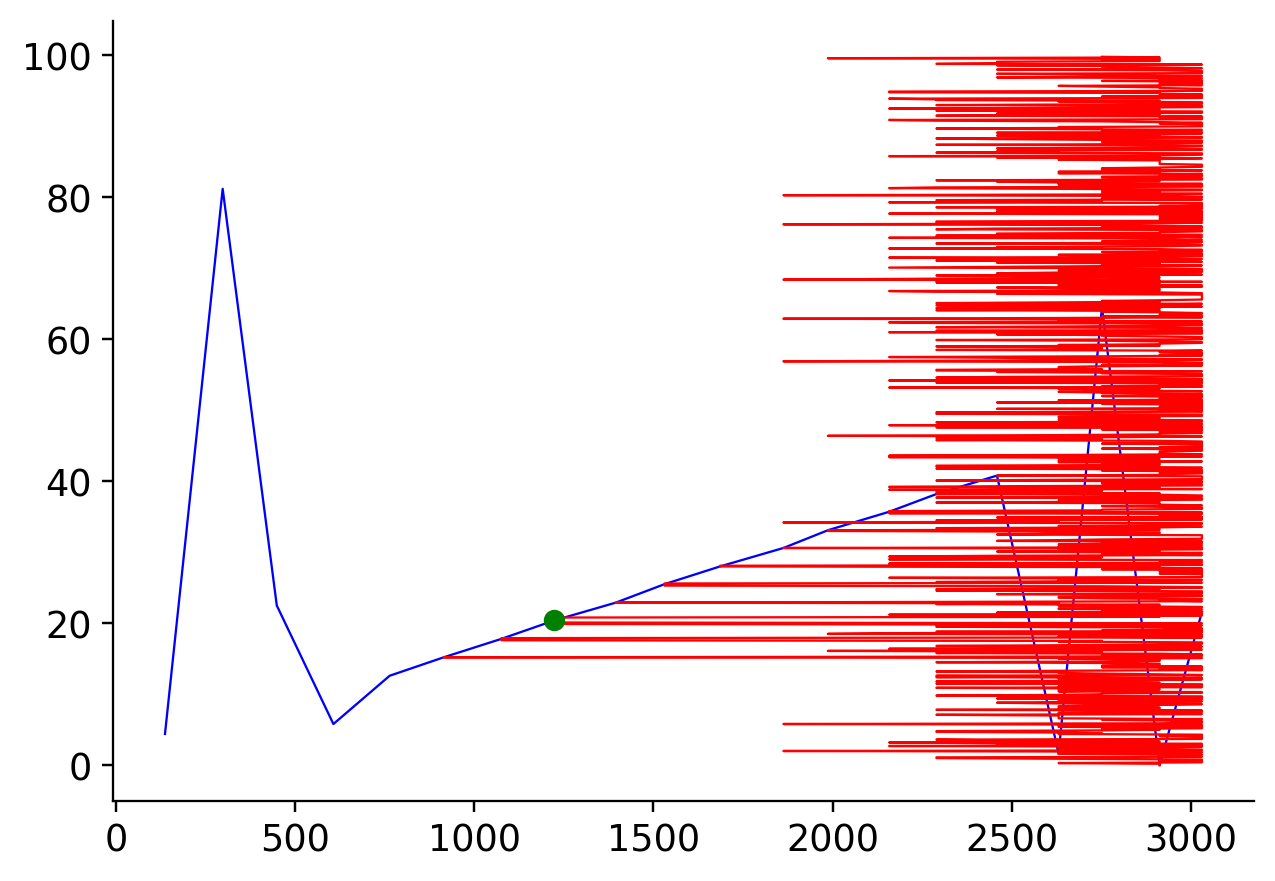

In [6]:
#da ich probleme mit dem imshow() befehl hatte, habe ich mich stattdessen in Campbell-diagramme eingelesen und versucht, so gut wie möglich die charakteristischen Eigenschaften eines Campbell-Diagrams selbst umzusetzen.
#dies hat aus mit unbekannten Gründen mal besser und mal schlechter geklappt, warum zB bei Prüfstand 4 der Bereich der eigenfrequenz so groß ist, ist mir nicht ganz verständlich, 
#hängt aber möglicherweise mit der diskreten Natur der Messdaten zusammen


#finden und plotten der frequenz der maximalen Amplitude jeder Drehzahl

#definieren der Laufvariable und der später zu plottenden Arrays
i = 0
final_X = []
final_Y = []

#while-Schleife zum Ablaufen aller Drehzahlen
while i < 20:
    
    #extrahieren der richtigen Messwerte zu jeder Drehzahl aus dem dict
    data = 'data_' + str(i)
    X = dict[data][1]
    Y_1 = dict[data][0][0]
    Y_2 = dict[data][0][1]
    
    #finden der frequenz, bei der die höchste Amplitude vorliegt
    loc_y = Y_1.argmax()
    y = Y_2[loc_y]

    #aufnehmen der Frequenz der höchsten Amplitude und der Drehzahl zu den final zu plottenden Arrays
    final_X.append(X)
    final_Y.append(y)

    #hochzählen für die while-Schleife
    i += 1

#plotten der Frequenzen der maximalen Amplitude über der zugehörigen Drehzahl
plt.plot(final_X, final_Y, 'b')


#finden und plotten der Drehzahlen, bei denen bei jeder Frequenz die maximale Amplitude auftritt
#außerdem suche der Eigenfrequenz durch suchen der overall größten auftretenden Amplitude

#definieren der Laufvariable und der später zu plottenden Arrays
i = 0
i_s = []
true_ys = []

#und halte-Array für spätere Suche nach maximaler Amplitude
zs = []

#while-Schleife zum Ablaufen aller Frequenzen
while i < 999:

    #definieren einer zweiten Laufvariable und eines Arrays zur zwischenablage der jeweils zur grade abgefragten Frequenz zugehörigen Amplitude bei jeder Drehzahl
    ys = []
    j=0

    #while-Schleife zum abfragen aller Drehzahlen
    while j < 20:

        #auslesen der jeweils richtigen daten zur jeweiligen Drehzahl aus dem dict
        data = 'data_' + str(j)
        Y = dict[data][0][0]

        #Aufnehmen der zur aktuellen Frequenz gehörenden Amplitude bei dieser Drahzahl in die Zwischenablage
        ys.append(Y[i])

        #hochzählen für die while-Schleife
        j += 1

    #finden der Drehzahl der maximalen Amplitude bei der entsprechenden Frequenz i*0,1 
    
    loc_y = np.array(ys).argmax()
    y =final_X[loc_y]
    z =ys[loc_y]

    #hinzufügen der richtigen Drehzahl und der Frequenz zu den zu plottenden Arrays, außerdem hinzufügen der höchsten Amplitude bei dieser Drehzahl zu halte-Array
    true_ys.append(y)
    i_s.append(0.1*i)
    zs.append(z)

    #hochzählen für die while-Schleife
    i+= 1

#plotten der Drehzahl der höchsten Amplitude bei jeder Frequenz
plt.plot(true_ys, i_s, 'r')

#finden der Frequenz und Drahzahl, bei denen die maximale Amplitude auftritt
loc_max_z = np.array(zs).argmax()
highest_y = true_ys[loc_max_z]
i_von_z = i_s[loc_max_z]

#plotten von Frequenz und Drehzahl der maximalen Amplitude -> Eigenfrequenz
plt.plot(highest_y, i_von_z, 'go')


## Zweiter Datensatz: Prüfstand #4

#### 1. Einlesen der Mess- und Metadaten

In [7]:
path_measurement_folder = os.path.join(
    "measurement_data", 'data_20240109_104244_lavalrotor_01_04'
)  # path to the folder with H5-file and metadata
filename = 'data_20240109_104244_lavalrotor_01_04.h5'  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

#### 2. Verarbeitung der Messdaten

In [8]:
importlib.reload(m_postprocessing)  # reload functions

#zusammensetzten von Path & File Namen
path_and_file = path_measurement_folder + "/" + filename

#definieren von Laufvariable und Ziel-dictionary
i = 0
dict = {}

#schleife für alle 20 Messungen
while i < 20:
    
    #öffnen der hdf5 file
    with h5py.File(path_and_file) as f:
        
        #auslesen der daten als Arrays aus der hdf5
        a_x = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/acceleration_x"])
        a_y = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/acceleration_y"])
        a_z = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/acceleration_z"])
        time = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/timestamp"])
        
        #rpm wird als integer ausgelesen
        rpm = int(np.array(f[str(i)+"/RawData/" + uuid_motor_rpm + "/motor_rpm"]))
        
    #erhalten der vektoriellen Werte   
    v = m_postprocessing.get_vec_accel(a_x, a_y, a_z)
    
    #interpolieren der Werte
    int_v = m_postprocessing.interpolation(time, v, interpolation_points)
    
    #Fast-fourier-transformation der Werte und zusammenführen mit rpm
    data = m_postprocessing.my_fft_scaled(int_v, interpolation_points), rpm
    
    #speichern der daten für einfache Weiterverarbeitung
    dict['data_'+str(i)] = data
    
    #hochzählen für while-schleife
    i += 1

#das nur zum schönen ausgeben des dicts
import pprint 
pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(dict)    

#### 3. Darstellung mittels Campbell-Diagramm

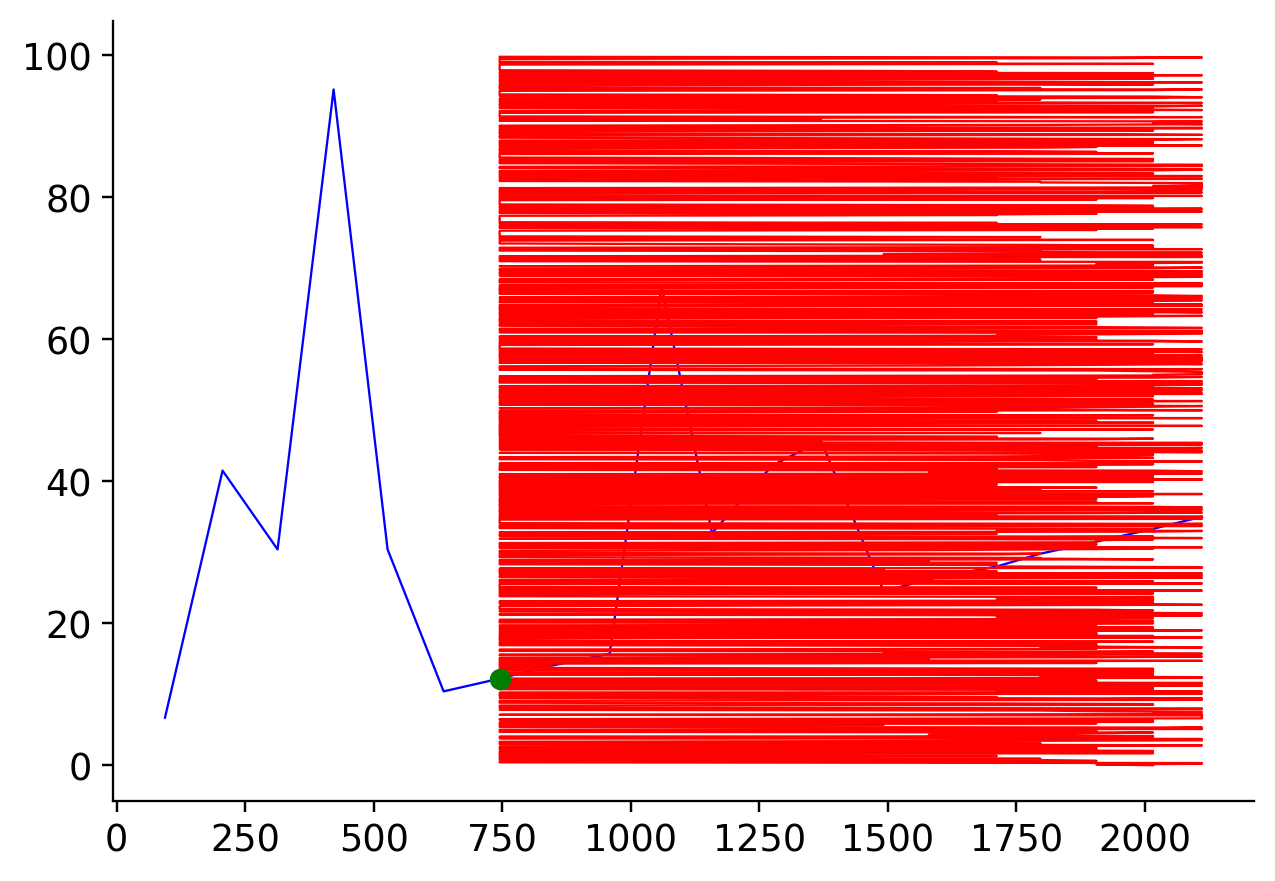

In [9]:
#da ich probleme mit dem imshow() befehl hatte, habe ich mich stattdessen in Campbell-diagramme eingelesen und versucht, so gut wie möglich die charakteristischen Eigenschaften eines Campbell-Diagrams selbst umzusetzen.
#dies hat aus mit unbekannten Gründen mal besser und mal schlechter geklappt, warum zB bei Prüfstand 4 der Bereich der eigenfrequenz so groß ist, ist mir nicht ganz verständlich, 
#hängt aber möglicherweise mit der diskreten Natur der Messdaten zusammen


#finden und plotten der frequenz der maximalen Amplitude jeder Drehzahl

#definieren der Laufvariable und der später zu plottenden Arrays
i = 0
final_X = []
final_Y = []

#while-Schleife zum Ablaufen aller Drehzahlen
while i < 20:
    
    #extrahieren der richtigen Messwerte zu jeder Drehzahl aus dem dict
    data = 'data_' + str(i)
    X = dict[data][1]
    Y_1 = dict[data][0][0]
    Y_2 = dict[data][0][1]
    
    #finden der frequenz, bei der die höchste Amplitude vorliegt
    loc_y = Y_1.argmax()
    y = Y_2[loc_y]

    #aufnehmen der Frequenz der höchsten Amplitude und der Drehzahl zu den final zu plottenden Arrays
    final_X.append(X)
    final_Y.append(y)

    #hochzählen für die while-Schleife
    i += 1

#plotten der Frequenzen der maximalen Amplitude über der zugehörigen Drehzahl
plt.plot(final_X, final_Y, 'b')


#finden und plotten der Drehzahlen, bei denen bei jeder Frequenz die maximale Amplitude auftritt
#außerdem suche der Eigenfrequenz durch suchen der overall größten auftretenden Amplitude

#definieren der Laufvariable und der später zu plottenden Arrays
i = 0
i_s = []
true_ys = []

#und halte-Array für spätere Suche nach maximaler Amplitude
zs = []

#while-Schleife zum Ablaufen aller Frequenzen
while i < 999:

    #definieren einer zweiten Laufvariable und eines Arrays zur zwischenablage der jeweils zur grade abgefragten Frequenz zugehörigen Amplitude bei jeder Drehzahl
    ys = []
    j=0

    #while-Schleife zum abfragen aller Drehzahlen
    while j < 20:

        #auslesen der jeweils richtigen daten zur jeweiligen Drehzahl aus dem dict
        data = 'data_' + str(j)
        Y = dict[data][0][0]

        #Aufnehmen der zur aktuellen Frequenz gehörenden Amplitude bei dieser Drahzahl in die Zwischenablage
        ys.append(Y[i])

        #hochzählen für die while-Schleife
        j += 1

    #finden der Drehzahl der maximalen Amplitude bei der entsprechenden Frequenz i*0,1 
    
    loc_y = np.array(ys).argmax()
    y =final_X[loc_y]
    z =ys[loc_y]

    #hinzufügen der richtigen Drehzahl und der Frequenz zu den zu plottenden Arrays, außerdem hinzufügen der höchsten Amplitude bei dieser Drehzahl zu halte-Array
    true_ys.append(y)
    i_s.append(0.1*i)
    zs.append(z)

    #hochzählen für die while-Schleife
    i+= 1

#plotten der Drehzahl der höchsten Amplitude bei jeder Frequenz
plt.plot(true_ys, i_s, 'r')

#finden der Frequenz und Drahzahl, bei denen die maximale Amplitude auftritt
loc_max_z = np.array(zs).argmax()
highest_y = true_ys[loc_max_z]
i_von_z = i_s[loc_max_z]

#plotten von Frequenz und Drehzahl der maximalen Amplitude -> Eigenfrequenz
plt.plot(highest_y, i_von_z, 'go')


## Dritter Datensatz: Prüfstand #2

#### 1. Einlesen der Mess- und Metadaten

In [10]:
path_measurement_folder = os.path.join(
    "measurement_data", 'data_20240102_100928_lavalrotor_01_02'
)  # path to the folder with H5-file and metadata
filename = 'data_20240102_100928_lavalrotor_01_02.h5'  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

#### 2. Verarbeitung der Messdaten

In [11]:
importlib.reload(m_postprocessing)  # reload functions

#zusammensetzten von Path & File Namen
path_and_file = path_measurement_folder + "/" + filename

#definieren von Laufvariable und Ziel-dictionary
i = 0
dict = {}

#schleife für alle 20 Messungen
while i < 20:
    
    #öffnen der hdf5 file
    with h5py.File(path_and_file) as f:
        
        #auslesen der daten als Arrays aus der hdf5
        a_x = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/acceleration_x"])
        a_y = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/acceleration_y"])
        a_z = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/acceleration_z"])
        time = np.array(f[str(i)+"/RawData/" + uuid_acceleration + "/timestamp"])
        
        #rpm wird als integer ausgelesen
        rpm = int(np.array(f[str(i)+"/RawData/" + uuid_motor_rpm + "/motor_rpm"]))
        
    #erhalten der vektoriellen Werte   
    v = m_postprocessing.get_vec_accel(a_x, a_y, a_z)
    
    #interpolieren der Werte
    int_v = m_postprocessing.interpolation(time, v, interpolation_points)
    
    #Fast-fourier-transformation der Werte und zusammenführen mit rpm
    data = m_postprocessing.my_fft_scaled(int_v, interpolation_points), rpm
    
    #speichern der daten für einfache Weiterverarbeitung
    dict['data_'+str(i)] = data
    
    #hochzählen für while-schleife
    i += 1

#das nur zum schönen ausgeben des dicts
import pprint 
pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(dict)    

#### 3. Darstellung mittels Campbell-Diagramm

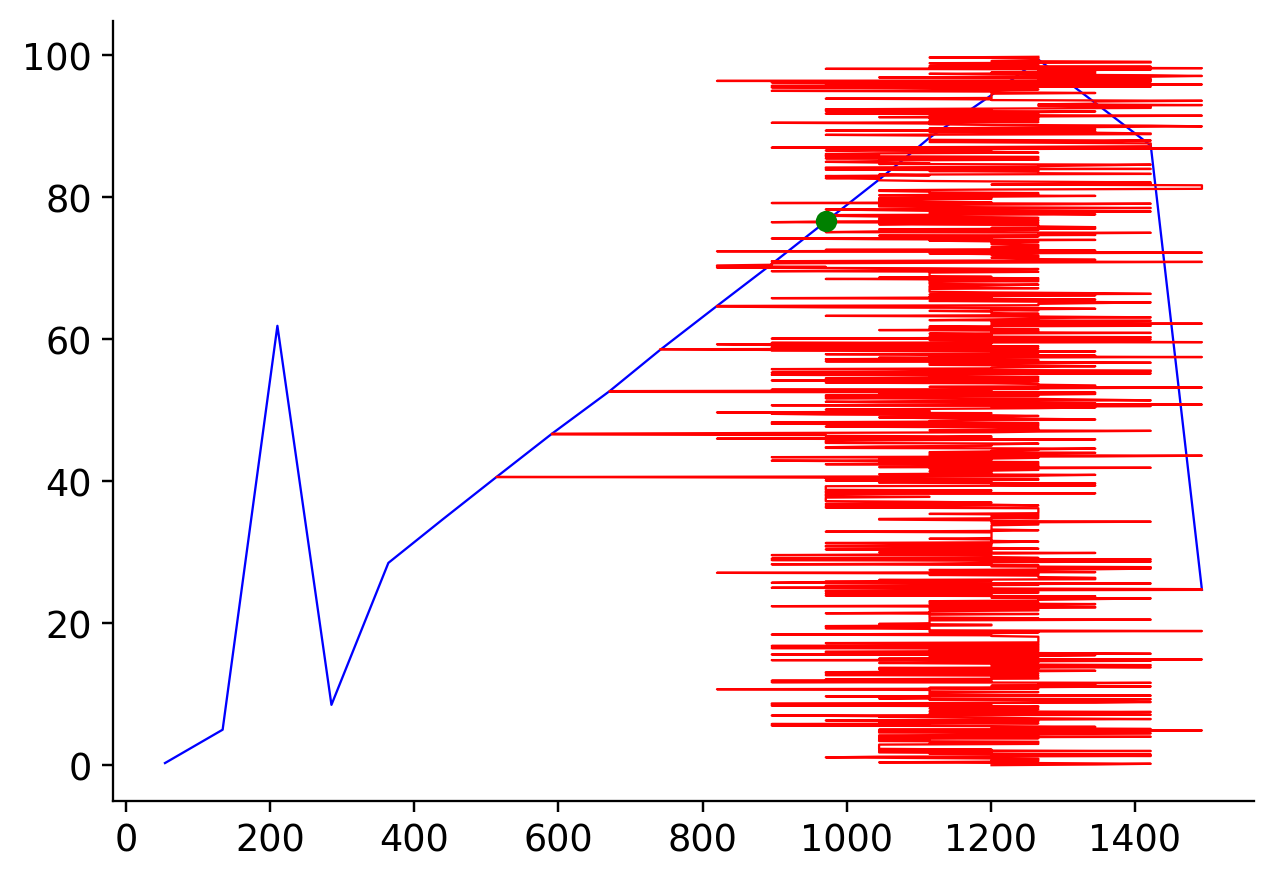

In [12]:
#da ich probleme mit dem imshow() befehl hatte, habe ich mich stattdessen in Campbell-diagramme eingelesen und versucht, so gut wie möglich die charakteristischen Eigenschaften eines Campbell-Diagrams selbst umzusetzen.
#dies hat aus mit unbekannten Gründen mal besser und mal schlechter geklappt, warum zB bei Prüfstand 4 der Bereich der eigenfrequenz so groß ist, ist mir nicht ganz verständlich, 
#hängt aber möglicherweise mit der diskreten Natur der Messdaten zusammen


#finden und plotten der frequenz der maximalen Amplitude jeder Drehzahl

#definieren der Laufvariable und der später zu plottenden Arrays
i = 0
final_X = []
final_Y = []

#while-Schleife zum Ablaufen aller Drehzahlen
while i < 20:
    
    #extrahieren der richtigen Messwerte zu jeder Drehzahl aus dem dict
    data = 'data_' + str(i)
    X = dict[data][1]
    Y_1 = dict[data][0][0]
    Y_2 = dict[data][0][1]
    
    #finden der frequenz, bei der die höchste Amplitude vorliegt
    loc_y = Y_1.argmax()
    y = Y_2[loc_y]

    #aufnehmen der Frequenz der höchsten Amplitude und der Drehzahl zu den final zu plottenden Arrays
    final_X.append(X)
    final_Y.append(y)

    #hochzählen für die while-Schleife
    i += 1

#plotten der Frequenzen der maximalen Amplitude über der zugehörigen Drehzahl
plt.plot(final_X, final_Y, 'b')


#finden und plotten der Drehzahlen, bei denen bei jeder Frequenz die maximale Amplitude auftritt
#außerdem suche der Eigenfrequenz durch suchen der overall größten auftretenden Amplitude

#definieren der Laufvariable und der später zu plottenden Arrays
i = 0
i_s = []
true_ys = []

#und halte-Array für spätere Suche nach maximaler Amplitude
zs = []

#while-Schleife zum Ablaufen aller Frequenzen
while i < 999:

    #definieren einer zweiten Laufvariable und eines Arrays zur zwischenablage der jeweils zur grade abgefragten Frequenz zugehörigen Amplitude bei jeder Drehzahl
    ys = []
    j=0

    #while-Schleife zum abfragen aller Drehzahlen
    while j < 20:

        #auslesen der jeweils richtigen daten zur jeweiligen Drehzahl aus dem dict
        data = 'data_' + str(j)
        Y = dict[data][0][0]

        #Aufnehmen der zur aktuellen Frequenz gehörenden Amplitude bei dieser Drahzahl in die Zwischenablage
        ys.append(Y[i])

        #hochzählen für die while-Schleife
        j += 1

    #finden der Drehzahl der maximalen Amplitude bei der entsprechenden Frequenz i*0,1 
    
    loc_y = np.array(ys).argmax()
    y =final_X[loc_y]
    z =ys[loc_y]

    #hinzufügen der richtigen Drehzahl und der Frequenz zu den zu plottenden Arrays, außerdem hinzufügen der höchsten Amplitude bei dieser Drehzahl zu halte-Array
    true_ys.append(y)
    i_s.append(0.1*i)
    zs.append(z)

    #hochzählen für die while-Schleife
    i+= 1

#plotten der Drehzahl der höchsten Amplitude bei jeder Frequenz
plt.plot(true_ys, i_s, 'r')

#finden der Frequenz und Drahzahl, bei denen die maximale Amplitude auftritt
loc_max_z = np.array(zs).argmax()
highest_y = true_ys[loc_max_z]
i_von_z = i_s[loc_max_z]

#plotten von Frequenz und Drehzahl der maximalen Amplitude -> Eigenfrequenz
plt.plot(highest_y, i_von_z, 'go')


## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Mittels des (von mir recht einzigartig zusammengestellten) Campbell-Diagrammes lässt sich sehr klar die eigenfrequenz des Systems ablesen. die von uns errechnete Eigenfrequenz weicht natürlich von der hier dargestellten eigenfrequenz ab.
Allerdings ist dies in Anbetzracht der vielen Vereinfachungen (zB Trägheitsmoment der Achse vernachlässigt) nicht verwunderlich, und die Ergebnisse nicht alzu weit voneinander Entfernt.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Unsere selbst errechnete Eigenfrequez war 1034, das Campbell-Diagramm zeigt sie eher bei 1200. Das entspricht einer Abweichung des errechneten Ergebnisses von etwa 14%.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Die Durchführung des Versuches selbst war interessant zu sehen, und das nähere Auseinandersetzen mit Campbell-Diagrammen hat für ein besseres Verrständnis dieses Ingenieurswissenschaftlichen
Werkzeugs geführt.